# Neural Network classification with Pytorch

In [54]:
import sklearn
from sklearn.datasets import make_circles

In [55]:
n_samples = 1000
x, y = make_circles(n_samples=n_samples, noise=0.05)
x[:5], y[:5]

(array([[ 0.44823202,  0.65159948],
        [ 0.94903479, -0.10393107],
        [-0.05339523,  0.73823263],
        [-0.52589481,  0.58913144],
        [ 0.17105239,  0.86362087]]),
 array([1, 0, 1, 1, 0], dtype=int64))

In [56]:
import pandas as pd
circles = pd.DataFrame({"X0": x[:, 0], "X1": x[:, 1], "label": y})
circles.head(10)

,X0,X1,label
0,0.448232,0.651599,1
1,0.949035,-0.103931,0
2,-0.053395,0.738233,1
3,-0.525895,0.589131,1
4,0.171052,0.863621,0
5,1.025874,0.251047,0
6,-0.384447,-0.817075,1
7,0.769849,-0.615131,0
8,0.291399,-0.796937,1
9,-0.780975,-0.130934,1


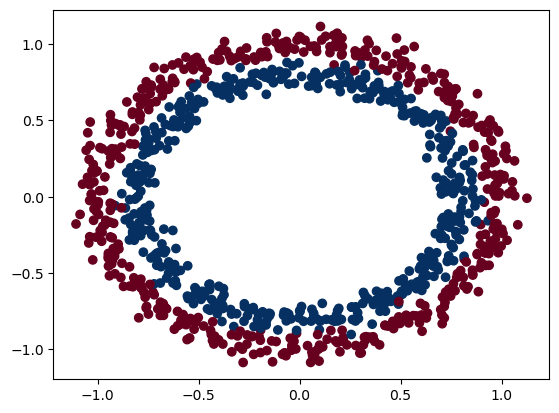

In [57]:
import matplotlib.pyplot as plt
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.RdBu)

In [58]:
x.shape, y.shape

((1000, 2), (1000,))

In [59]:
import torch
x = torch.from_numpy(x).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)


In [60]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

## 2. Building a model

In [61]:
import torch
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [62]:
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
x_train, y_train, x_test, y_test

(tensor([[-0.3570,  0.7039],
         [-0.9951, -0.1155],
         [ 0.5879,  0.7008],
         ...,
         [ 0.9854,  0.4246],
         [ 0.8569, -0.5038],
         [ 0.4281,  0.9212]], device='cuda:0'),
 tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
         0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
         1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
         1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
         0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
         1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
         0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
         1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,

In [63]:
class circle_model_v0(nn.Module):
    def __init__(self, input_features=2, hidden_dim=4, output_features=1):
        super(circle_model_v0, self).__init__()
        self.fc1 = nn.Linear(input_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_features)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [64]:
model_0 = circle_model_v0().to(device)
model_0

circle_model_v0(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [65]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [66]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1045, -0.3301],
                      [ 0.1802, -0.3258],
                      [-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997]], device='cuda:0')),
             ('0.bias',
              tensor([-0.4252,  0.0667, -0.6984,  0.6386, -0.6007], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.3453,  0.0744, -0.1452,  0.2764,  0.0697]], device='cuda:0')),
             ('1.bias', tensor([0.3613], device='cuda:0'))])

In [67]:
untrained_predict = model_0(x_train)
torch.round(untrained_predict[:5]), y_train[:5]

(tensor([[0.],
         [0.],
         [0.],
         [0.],
         [1.]], device='cuda:0', grad_fn=<RoundBackward0>),
 tensor([1., 0., 0., 0., 0.], device='cuda:0'))

In [68]:
# Set up loss function
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1)

def calculate_accuracy(y_true, y_pred):
    correct = torch.eq(y_pred.round(), y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy * 100

In [69]:
# Build a training loop
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(x_test.to(device))
y_logits

tensor([[0.5950],
        [0.6542],
        [0.5800],
        [0.2657],
        [0.4682],
        [0.3345],
        [0.6667],
        [0.4002],
        [0.4852],
        [0.5756],
        [0.7147],
        [0.5780],
        [0.4284],
        [0.5270],
        [0.2850],
        [0.3982],
        [0.5784],
        [0.3586],
        [0.2171],
        [0.2511],
        [0.4163],
        [0.1379],
        [0.3573],
        [0.2320],
        [0.1812],
        [0.4688],
        [0.1822],
        [0.6425],
        [0.7043],
        [0.5646],
        [0.6505],
        [0.2711],
        [0.2181],
        [0.5852],
        [0.5305],
        [0.6336],
        [0.2846],
        [0.7577],
        [0.1888],
        [0.2547],
        [0.1737],
        [0.2036],
        [0.3571],
        [0.1965],
        [0.4347],
        [0.4042],
        [0.7128],
        [0.3951],
        [0.3115],
        [0.2583],
        [0.7603],
        [0.6806],
        [0.3019],
        [0.7144],
        [0.4974],
        [0

In [70]:
y_test

tensor([1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
        1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
        1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
        1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
        1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
        0., 0.], device='cuda:0')

In [71]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6445],
        [0.6580],
        [0.6411],
        [0.5660],
        [0.6150],
        [0.5829],
        [0.6608],
        [0.5987],
        [0.6190],
        [0.6401],
        [0.6714],
        [0.6406],
        [0.6055],
        [0.6288],
        [0.5708],
        [0.5983],
        [0.6407],
        [0.5887],
        [0.5541],
        [0.5625],
        [0.6026],
        [0.5344],
        [0.5884],
        [0.5577],
        [0.5452],
        [0.6151],
        [0.5454],
        [0.6553],
        [0.6692],
        [0.6375],
        [0.6571],
        [0.5674],
        [0.5543],
        [0.6423],
        [0.6296],
        [0.6533],
        [0.5707],
        [0.6808],
        [0.5471],
        [0.5633],
        [0.5433],
        [0.5507],
        [0.5883],
        [0.5490],
        [0.6070],
        [0.5997],
        [0.6710],
        [0.5975],
        [0.5773],
        [0.5642],
        [0.6814],
        [0.6639],
        [0.5749],
        [0.6714],
        [0.6218],
        [0

In [72]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(x_test.to(device))))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_pred_labels.squeeze()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [73]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 2000

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)
for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = calculate_accuracy(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.inference_mode():
        test_logits = model_0(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = calculate_accuracy(y_test, test_pred)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.72239 | Train Acc: 49.62% | Test Loss: 0.72313 | Test Acc: 51.50%
Epoch: 10 | Train Loss: 0.70179 | Train Acc: 58.88% | Test Loss: 0.70712 | Test Acc: 57.00%
Epoch: 20 | Train Loss: 0.69630 | Train Acc: 52.25% | Test Loss: 0.70303 | Test Acc: 49.50%
Epoch: 30 | Train Loss: 0.69472 | Train Acc: 51.25% | Test Loss: 0.70176 | Test Acc: 48.50%
Epoch: 40 | Train Loss: 0.69417 | Train Acc: 51.25% | Test Loss: 0.70111 | Test Acc: 48.00%
Epoch: 50 | Train Loss: 0.69390 | Train Acc: 51.12% | Test Loss: 0.70060 | Test Acc: 48.50%
Epoch: 60 | Train Loss: 0.69372 | Train Acc: 51.25% | Test Loss: 0.70013 | Test Acc: 47.00%
Epoch: 70 | Train Loss: 0.69359 | Train Acc: 51.12% | Test Loss: 0.69970 | Test Acc: 47.00%
Epoch: 80 | Train Loss: 0.69348 | Train Acc: 51.25% | Test Loss: 0.69931 | Test Acc: 46.50%
Epoch: 90 | Train Loss: 0.69339 | Train Acc: 51.12% | Test Loss: 0.69895 | Test Acc: 46.00%
Epoch: 100 | Train Loss: 0.69331 | Train Acc: 51.25% | Test Loss: 0.69864 | Test 

Epoch: 180 | Train Loss: 0.69300 | Train Acc: 51.00% | Test Loss: 0.69706 | Test Acc: 44.00%
Epoch: 190 | Train Loss: 0.69298 | Train Acc: 51.00% | Test Loss: 0.69695 | Test Acc: 43.50%
Epoch: 200 | Train Loss: 0.69296 | Train Acc: 50.88% | Test Loss: 0.69684 | Test Acc: 43.50%
Epoch: 210 | Train Loss: 0.69295 | Train Acc: 50.75% | Test Loss: 0.69675 | Test Acc: 43.50%
Epoch: 220 | Train Loss: 0.69293 | Train Acc: 51.00% | Test Loss: 0.69666 | Test Acc: 43.50%
Epoch: 230 | Train Loss: 0.69292 | Train Acc: 51.12% | Test Loss: 0.69659 | Test Acc: 43.50%
Epoch: 240 | Train Loss: 0.69291 | Train Acc: 51.12% | Test Loss: 0.69652 | Test Acc: 43.50%
Epoch: 250 | Train Loss: 0.69290 | Train Acc: 51.00% | Test Loss: 0.69646 | Test Acc: 44.00%
Epoch: 260 | Train Loss: 0.69289 | Train Acc: 51.00% | Test Loss: 0.69640 | Test Acc: 44.00%
Epoch: 270 | Train Loss: 0.69288 | Train Acc: 51.00% | Test Loss: 0.69635 | Test Acc: 45.00%
Epoch: 280 | Train Loss: 0.69288 | Train Acc: 51.00% | Test Loss: 0.69

### The model isn't learning anything, so we evaluate it 

In [74]:
import requests
from pathlib import Path
# Download helper function
if Path("helper_function.py").is_file() is False:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
with open("helper_functions.py", "w") as f:
    f.write(request.content.decode("utf-8"))

from helper_functions import plot_decision_boundary, plot_predictions
    

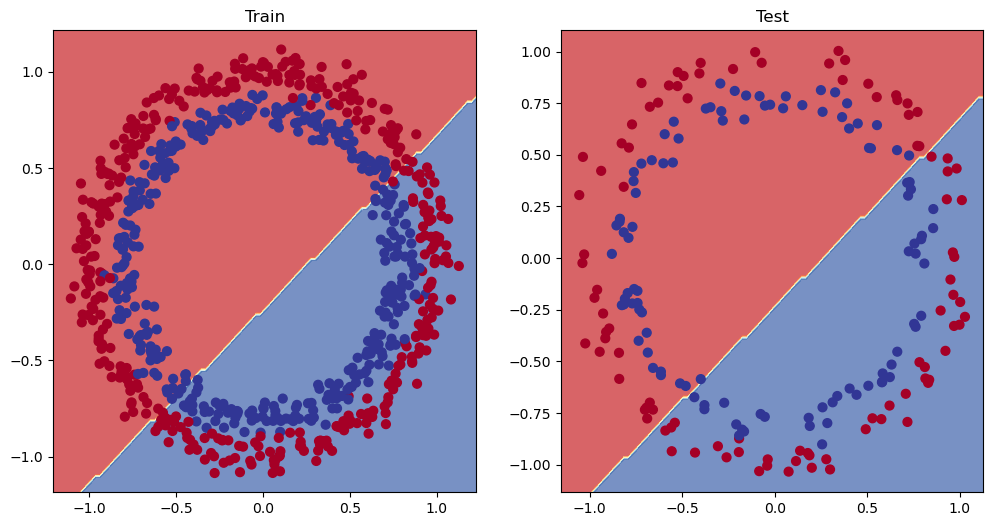

In [75]:
import matplotlib.pyplot as plt
# Plot the decision boundary for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test)

## 5. Improving model

In [79]:
# Set up new model
model1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=1),
).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=1, bias=True)
)

In [77]:
# Train model
epochs = 1000
for epoch in range(epochs):
    model1.train()
    y_logits = model1(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = calculate_accuracy(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.inference_mode():
        test_logits = model1(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = calculate_accuracy(y_test, test_pred)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.69175 | Train Acc: 57.75% | Test Loss: 0.68894 | Test Acc: 48.50%
Epoch: 100 | Train Loss: 0.04209 | Train Acc: 98.75% | Test Loss: 0.05916 | Test Acc: 97.50%
Epoch: 200 | Train Loss: 0.03683 | Train Acc: 98.75% | Test Loss: 0.06484 | Test Acc: 97.50%
Epoch: 300 | Train Loss: 0.03512 | Train Acc: 98.75% | Test Loss: 0.06773 | Test Acc: 97.50%
Epoch: 400 | Train Loss: 0.03410 | Train Acc: 98.88% | Test Loss: 0.07047 | Test Acc: 97.50%
Epoch: 500 | Train Loss: 0.03323 | Train Acc: 98.75% | Test Loss: 0.07146 | Test Acc: 97.00%
Epoch: 600 | Train Loss: 0.03223 | Train Acc: 98.88% | Test Loss: 0.07497 | Test Acc: 97.50%
Epoch: 700 | Train Loss: 0.03055 | Train Acc: 98.88% | Test Loss: 0.07668 | Test Acc: 97.50%
Epoch: 800 | Train Loss: 0.02877 | Train Acc: 98.88% | Test Loss: 0.07935 | Test Acc: 97.00%
Epoch: 900 | Train Loss: 0.02610 | Train Acc: 98.88% | Test Loss: 0.08234 | Test Acc: 98.00%


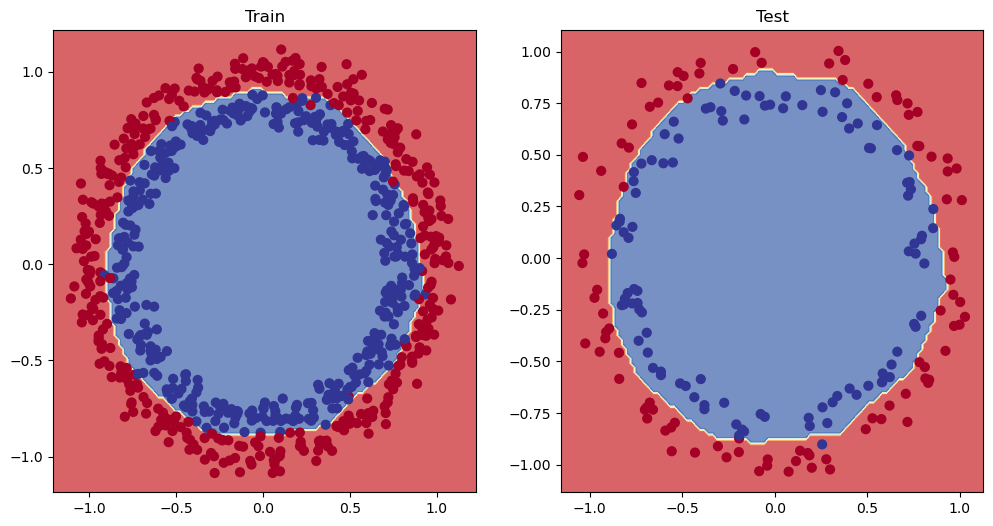

In [78]:
# show decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, x_test, y_test)